In [1]:
!wget http://www.ifp.illinois.edu/%7Evuongle2/helen/data/annotation.zip


Redirecting output to ‘wget-log’.


In [2]:
!wget http://www.ifp.illinois.edu/%7Evuongle2/helen/data/train_1.zip


Redirecting output to ‘wget-log.1’.


In [3]:
!unzip annotation.zip
!unzip train_1.zip

Archive:  annotation.zip
   creating: annotation/
  inflating: annotation/1.txt        
  inflating: annotation/10.txt       
  inflating: annotation/100.txt      
  inflating: annotation/1000.txt     
  inflating: annotation/1001.txt     
  inflating: annotation/1002.txt     
  inflating: annotation/1003.txt     
  inflating: annotation/1004.txt     
  inflating: annotation/1005.txt     
  inflating: annotation/1006.txt     
  inflating: annotation/1007.txt     
  inflating: annotation/1008.txt     
  inflating: annotation/1009.txt     
  inflating: annotation/101.txt      
  inflating: annotation/1010.txt     
  inflating: annotation/1011.txt     
  inflating: annotation/1012.txt     
  inflating: annotation/1013.txt     
  inflating: annotation/1014.txt     
  inflating: annotation/1015.txt     
  inflating: annotation/1016.txt     
  inflating: annotation/1017.txt     
  inflating: annotation/1018.txt     
  inflating: annotation/1019.txt     
  inflating: annotation/102.txt      


In [4]:
import cv2
import numpy as np
import keras
from keras.applications import vgg16 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [0]:
filename = "train_1/100040721_1.jpg"

# opencv - load original before it's resized
img = cv2.imread(filename)

# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels). Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)

# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())

Plot the landmarks from the labels (this is what we want our model to learn)

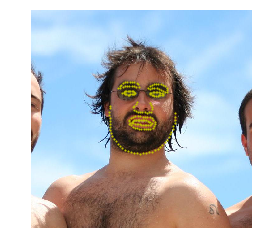

In [6]:
import matplotlib.pyplot as plt
img = plt.imread(filename)
implot = plt.imshow(img)
with open("annotation/2.txt") as f:
  next(f)
  for line in f:
    coords = line.split(',')
    x = coords[0].strip().split('.')[0]
    y = coords[1].strip().split('.')[0]
    #cv2.circle(img, (int(x), int(y)), 5, (255,255,0), -1)
    plt.scatter([int(x)], [int(y)], c='y', s=3)
plt.axis('off')
plt.show()

Define our Loss function (RMSE is a common loss function for continuous value outputs)

In [0]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

Load our model (pre-trained with ImageNet weights, but missing the final/top layer so that we can output our estimated landmark values instead of the ImageNet 1K class probabilities).  I went with VGG16, but you can replace this with any network that you'd like (i.e., ResNet, MobileNet, DenseNet, etc...).  With VGG16, and some others that Keras supports "out of the box", the pre-trained ImageNet weights should automatically download for you and be loaded into the network/model.

In [9]:
# load the VGG model
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(model.summary())

# freeze the layers which you don't want to train (first 5, in this case)
#for layer in model.layers[:5]:
#    layer.trainable = False

# adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(4096, activation="linear")(x)
#x = Dropout(0.5)(x)
x = Dense(1024, activation="linear")(x)
predictions = Dense(388, activation="linear")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(optimizer = "rmsprop", loss = root_mean_squared_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


We're going to read in the label (facial feature landmark values) that pertains to our single input image

In [12]:
mylabel = []
with open("annotation/2.txt") as f:
  next(f)
  for line in f:
    coords = line.split(',')
    x = coords[0].strip()#.split('.')[0]
    mylabel.append(x)
    y = coords[1].strip()#.split('.')[0]
    mylabel.append(y)
print(mylabel)

['256', '308', '254.41', '317.45', '253.36', '327.79', '253.28', '338.25', '254.78', '348.26', '255.25', '358', '254.76', '368.01', '255.02', '377.94', '255.91', '388.8', '258.52', '398.47', '263.45', '407.3', '269.55', '415.23', '275.99', '423.14', '281.28', '431.23', '287.49', '440.08', '295.2', '446.53', '303.91', '450.84', '313.31', '454.63', '322.52', '458.74', '332.39', '460.99', '342.35', '462.9', '352.29', '463.87', '362.38', '462.96', '372.88', '461.3', '382.32', '459.38', '392.89', '457.26', '401.5', '453.12', '410.83', '447.86', '418.79', '441.11', '425.48', '434.1', '432.5', '426.84', '439.04', '419.38', '445.24', '411.33', '450.6', '401.75', '454.97', '392.73', '458.71', '383.51', '460.61', '373.47', '465.48', '364.42', '465.45', '354.35', '465.08', '344.5', '465.1', '333.85', '343.65', '297.2', '339.27', '303.07', '333.66', '308.17', '330.13', '314.38', '332.14', '321.07', '338.15', '325.98', '345.1', '328.96', '352.41', '329.81', '359.98', '330.19', '367.23', '330.9', '3

We will scale down these pixel values (i.e., 620,645 ...) to be values between 0 and 1 (and we will scale the model results back up afterwards).  We do this because VGG16 (and most) pretrained networks/models are using activation functions like ReLU, Sigmoid, etc... which provide results between 0-1 (or even between -1 and 1 in the case of "tanh" function).  This is done to improve performance during backpropagation

In [13]:
# scale/normalize the label input
mylabel_np = np.array(mylabel)
label_data = np.reshape(mylabel_np,(-1,1))
scaler = MinMaxScaler((0,1))
mylabel_np_normd = scaler.fit_transform(label_data)
mylabel_np_normd_flat = mylabel_np_normd.astype(float).flatten()
label_batch = np.expand_dims(mylabel_np_normd_flat, axis=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype <U6 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Let's attempt to fit our network to our input and label with only a few (10, in this case) epochs/passes, and then plot the results (this should only take a few seconds if GPU is enabled.  To enable: Menu -> Runtime -> Change runtime type -> Hardware accelerator -> Select GPU -> Save)

In [14]:
# fit the model
model_final.fit(image_batch, label_batch, batch_size=1, epochs=10)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 27.0960
Epoch 2/10
1/1 [==============================] - 0s 193ms/step - loss: 15952.4756
Epoch 3/10
1/1 [==============================] - 0s 191ms/step - loss: 2107.2590
Epoch 4/10
1/1 [==============================] - 0s 197ms/step - loss: 21.7363
Epoch 5/10
1/1 [==============================] - 0s 193ms/step - loss: 21.3349
Epoch 6/10
1/1 [==============================] - 0s 193ms/step - loss: 0.6711
Epoch 7/10
1/1 [==============================] - 0s 188ms/step - loss: 4.0974
Epoch 8/10
1/1 [==============================] - 0s 192ms/step - loss: 0.5360
Epoch 9/10
1/1 [==============================] - 0s 189ms/step - loss: 0.5291
Epoch 10/10
1/1 [==============================] - 0s 192ms/step - loss: 0.5225


We can see the numerical outputs, and compare to our label (2.txt)

In [15]:
# get the predicted probabilities for each class
predictions = model_final.predict(processed_image)
prediction_data = np.reshape(predictions,(-1,1))
prediction_data_normd = scaler.inverse_transform(prediction_data)
prediction_data_normd_flat = prediction_data_normd.astype(float).flatten()
print(prediction_data_normd_flat)

[229.5218811  239.33911133 229.81272888 228.35766602 235.11732483
 248.76359558 235.14115906 246.57891846 234.85385132 243.43621826
 236.89849854 234.62608337 241.58013916 237.11439514 229.66874695
 241.30334473 235.16056824 240.47117615 230.06813049 238.46156311
 254.42062378 233.79634094 230.06948853 248.44528198 237.84414673
 236.02325439 235.02552795 240.24832153 239.70909119 242.15287781
 233.91595459 231.06211853 240.43344116 239.19186401 231.69215393
 236.82774353 229.13088989 230.7230072  239.26011658 238.51612854
 236.50453186 247.51315308 249.33198547 240.78497314 233.2091217
 245.23478699 240.73129272 256.96408081 244.27000427 251.57736206
 234.75177002 239.92430115 233.96499634 241.42414856 236.8008728
 234.76524353 242.05447388 233.58383179 243.31690979 249.23175049
 245.11317444 248.15498352 247.53222656 242.79882812 238.60673523
 229.65350342 225.63026428 233.71762085 239.22453308 247.23469543
 236.804245   241.05419922 220.78086853 236.10171509 239.75222778
 242.1570892

Let's plot the results on our image

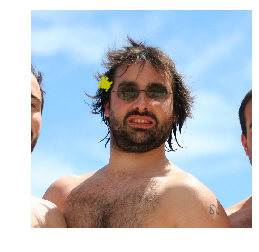

In [17]:
import matplotlib.pyplot as plt
img = plt.imread(filename) #image_name)
implot = plt.imshow(img)
# plot points and display image
data = prediction_data_normd_flat
for x,y in zip(data[0::2], data[1::2]):
  #cv2.circle(img, (int(x), int(y)), 1, (255,255,0), -1)
  plt.scatter([x], [y], s=3, c='y')
#plt.imshow(img)
plt.axis('off')
plt.show()

After only 10 epochs, you will likely see a cluster of yellow dots in one location of the image (perhaps near hair).  Let's train the model for 1500 epochs and check the results (this should take ~5 mins with GPU enabled).  If you're wondering, per the published paper associated with this dataset [http://www.ifp.illinois.edu/%7Evuongle2/helen/eccv2012_helen_final.pdf] a useful loss is somewhere around 0.04, so we may be able to get by with far fewer epochs; test it out if you want!

In [18]:
# fit the model
model_final.fit(image_batch, label_batch, batch_size=1, epochs=500)

Epoch 1/1500
1/1 [==============================] - 0s 234ms/step - loss: 0.5162
Epoch 2/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.5101
Epoch 3/1500
1/1 [==============================] - 0s 197ms/step - loss: 0.5041
Epoch 4/1500
1/1 [==============================] - 0s 194ms/step - loss: 0.4982
Epoch 5/1500
1/1 [==============================] - 0s 187ms/step - loss: 0.4924
Epoch 6/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.4867
Epoch 7/1500
1/1 [==============================] - 0s 190ms/step - loss: 0.4810
Epoch 8/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.4753
Epoch 9/1500
1/1 [==============================] - 0s 190ms/step - loss: 0.4697
Epoch 10/1500
1/1 [==============================] - 0s 190ms/step - loss: 0.4641
Epoch 11/1500
1/1 [==============================] - 0s 191ms/step - loss: 0.4586
Epoch 12/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.4530
Epoch 13/1500
1/1 [======

Get the predictions to be used for plotting, and we'll also print the upscaled pixel values again (this time they should much more closely resemble the values in our label: 2.txt)

In [23]:
# get the predicted probabilities for each class
predictions = model_final.predict(processed_image)
prediction_data = np.reshape(predictions,(-1,1))
prediction_data_normd = scaler.inverse_transform(prediction_data)
prediction_data_normd_flat = prediction_data_normd.astype(float).flatten()
print(prediction_data_normd_flat)

[260.28277588 306.26263428 249.60688782 311.07455444 249.84181213
 324.62869263 254.68060303 334.49966431 251.08970642 342.26116943
 251.50363159 351.07159424 246.43652344 360.6791687  256.74230957
 372.10214233 262.59606934 381.85656738 261.67047119 392.48919678
 262.17807007 400.69955444 270.30718994 406.25680542 270.63317871
 415.5255127  276.26373291 425.00881958 283.97427368 434.49420166
 289.65325928 437.54486084 298.47042847 441.11898804 311.82507324
 445.77947998 316.25695801 449.37054443 329.48443604 453.92224121
 339.21881104 452.50222778 346.41442871 452.56228638 357.24291992
 453.79638672 368.27880859 451.63269043 375.31091309 450.07159424
 385.44656372 451.54187012 394.58267212 445.55899048 404.09237671
 441.86105347 410.68972778 432.68643188 420.05490112 427.03805542
 424.24206543 420.08520508 432.33895874 411.02108765 438.73736572
 402.9006958  440.0350647  395.16064453 448.76498413 387.31988525
 451.45346069 376.48464966 453.31661987 370.33111572 458.45294189
 360.32067

Let's plot the results on our image, again.  This time we expect much better results!

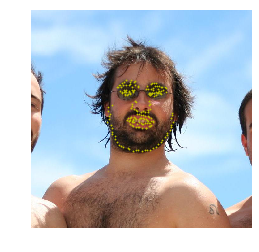

In [22]:
img = plt.imread(filename)
implot = plt.imshow(img)
# plot points and display image
data = prediction_data_normd_flat
for x,y in zip(data[0::2], data[1::2]):
  #cv2.circle(img, (int(x), int(y)), 1, (255,255,0), -1)
  plt.scatter([x], [y], s=2, c='y')
#plt.imshow(img)
plt.axis('off')
plt.show()

It's easy to see that we're now properly mapping the input to the expected output.  The facial feature landmarks are present and properly positioned: we see the jaw line, mouth and lips, nose, eyes and eyebrows.  

Now, let's test it on a new face, without further training the model

In [0]:
filename = "train_1/100032540_1.jpg"

# opencv - load original before it's resized
img = cv2.imread(filename)

# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels). Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)

# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())

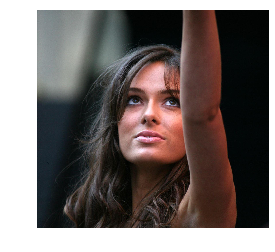

In [25]:
img = plt.imread(filename)
implot = plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
# get the predicted probabilities for each class
predictions = model_final.predict(processed_image)
prediction_data = np.reshape(predictions,(-1,1))
prediction_data_normd = scaler.inverse_transform(prediction_data)
prediction_data_normd_flat = prediction_data_normd.astype(float).flatten()
print(prediction_data_normd_flat)

[260.60153198 305.32818604 249.98194885 310.99884033 249.82139587
 324.84597778 254.27558899 335.03128052 251.59039307 342.42758179
 252.02038574 351.57244873 245.6580658  360.84671021 257.11331177
 372.35153198 261.93130493 381.47299194 261.39944458 392.68139648
 263.62124634 401.55831909 270.96078491 407.88232422 272.12545776
 417.0630188  276.21563721 425.19943237 283.86196899 435.33218384
 290.08682251 438.38092041 299.35971069 441.36611938 312.26895142
 446.29943848 316.81854248 450.17437744 331.58950806 453.85076904
 338.78268433 454.03793335 347.16189575 453.60296631 356.3939209
 454.46109009 369.04119873 451.63226318 375.7555542  450.95419312
 386.38046265 452.2578125  393.79089355 446.61804199 404.97045898
 442.75454712 411.21154785 433.55340576 420.23898315 427.72601318
 424.94311523 419.49456787 432.85186768 410.87463379 441.18310547
 402.87527466 440.18362427 396.91726685 450.04064941 387.22561646
 452.58853149 377.04919434 453.45019531 370.21258545 458.93933105
 360.851287

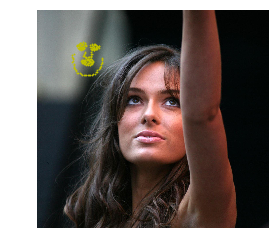

In [27]:
img = plt.imread(filename)
implot = plt.imshow(img)
# plot points and display image
data = prediction_data_normd_flat
for x,y in zip(data[0::2], data[1::2]):
  #cv2.circle(img, (int(x), int(y)), 1, (255,255,0), -1)
  plt.scatter([x], [y], s=2, c='y')
#plt.imshow(img)
plt.axis('off')
plt.show()

As you can see, it's quite goofy!  It's kind of displaying the facial landmarks in a recognizable way, but no where near the position that they belong given our new input image.  

HOMEWORK!! (or my next update): Begin to generalize the model by feeding in many, many examples from our dataset.  Currently, we're overfitted to our single input image.  Hence the poor results with new input.  Remember to keep back a portion of your training data to serve as validation data while you're training the model.  This way you can ensure that you're generalizing well over new samples which you're not tuning for.  If you're not sure what this means, then we'll cover that in the next update!